In [1]:
# Import libraries
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import os

In [2]:
# !unzip /content/Dataset.zip -d /content/extracted

In [3]:
# Load images
image_path = "./Dataset/"

images = []

for filename in os.listdir(image_path):
    img = tf.keras.preprocessing.image.load_img(f"{image_path}{filename}", target_size=(64, 64))
    img = tf.keras.preprocessing.image.img_to_array(img)
    images.append(img)

In [4]:
# Preprocess Images
images = np.asarray(images)

# Shuffle
indices = np.arange(images.shape[0])
np.random.shuffle(indices)
images = images[indices]

# Normalize
images = images.astype(np.float32) / 255.0

# Split dataset
total_data = len(images)
train_count = int(0.8 * total_data) # 80%

x_train = images[:train_count] # ambil 80% pertama
x_test = images[train_count : ] # ambil sisanya

print(f"Total Data: {total_data}")
print(f"Train: {x_train.shape}, Test: {x_test.shape}")

Total Data: 300
Train: (240, 64, 64, 3), Test: (60, 64, 64, 3)


In [5]:
BATCH_SIZE = 100
IMAGE_ORIGINAL_SHAPE = x_train.shape[1:]
IMAGE_SIZE = IMAGE_ORIGINAL_SHAPE[0] * IMAGE_ORIGINAL_SHAPE[1] * IMAGE_ORIGINAL_SHAPE[2]
HIDDEN_DIM = 512 
LATENT_DIM = 32 
MAX_EPOCHS = 60
LEARNING_RATE = 0.0001

print(IMAGE_ORIGINAL_SHAPE, IMAGE_SIZE)

(64, 64, 3) 12288


In [6]:
# Define model
class VAE(tf.keras.Model):
    def __init__(self, dim, **kwargs):
        super(VAE, self).__init__(**kwargs)

        h_dim = dim[0]
        z_dim = dim[1]

        self.fc1 = tf.keras.layers.Dense(h_dim, activation=tf.nn.relu)
        self.fc2 = tf.keras.layers.Dense(z_dim) 
        self.fc3 = tf.keras.layers.Dense(z_dim)
        self.fc4 = tf.keras.layers.Dense(h_dim, activation=tf.nn.relu)
        self.fc5 = tf.keras.layers.Dense(IMAGE_SIZE)

        self.encoder_batch_norm = tf.keras.layers.BatchNormalization()
        self.decoder_batch_norm = tf.keras.layers.BatchNormalization()

    def encode(self, x):
        x = self.encoder_batch_norm(x) 
        h = self.fc1(x) 
        return self.fc2(h), self.fc3(h) 

    def reparameterize(self, mu, log_var):
        std = tf.exp(log_var * 0.5)
        eps = tf.random.normal(tf.shape(std))
        return mu + eps * std 

    def decode_logits(self, z):
        h = self.fc4(z) 
        h = self.fc5(h) 
        return self.decoder_batch_norm(h) 

    def decode(self, z):
        return tf.nn.sigmoid(self.decode_logits(z))

    def call(self, inputs, training=None, mask=None):
        mu, log_var = self.encode(inputs) 
        z = self.reparameterize(mu, log_var) 
        x_recon_logits = self.decode_logits(z) 
        return x_recon_logits, mu, log_var

In [7]:
# Model initialization
model = VAE([HIDDEN_DIM, LATENT_DIM])

dummy = tf.zeros((BATCH_SIZE, IMAGE_SIZE))

model(dummy)

model.summary()

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

dataset = tf.data.Dataset.from_tensor_slices(x_train) 
dataset = dataset.shuffle(BATCH_SIZE * 5).batch(BATCH_SIZE) 

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  6291968   
                                                                 
 dense_1 (Dense)             multiple                  16416     
                                                                 
 dense_2 (Dense)             multiple                  16416     
                                                                 
 dense_3 (Dense)             multiple                  16896     
                                                                 
 dense_4 (Dense)             multiple                  6303744   
                                                                 
 batch_normalization (BatchN  multiple                 49152     
 ormalization)                                                   
                                                               

In [8]:
# Train model
loss_history = []
kl_div_history = []

for epoch in range(MAX_EPOCHS):
    for x in dataset:
        x = tf.reshape(x, [-1, IMAGE_SIZE])
        with tf.GradientTape() as tape:
            x_reconstruction_logits, mu, log_var = model(x)

            reconstruction_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_reconstruction_logits)
            reconstruction_loss = tf.reduce_sum(reconstruction_loss) / BATCH_SIZE

            kl_div = -0.5 * tf.reduce_sum(1. + log_var - tf.square(mu) - tf.exp(log_var), axis = -1)
            kl_div = tf.reduce_mean(kl_div)

            loss = tf.reduce_mean(reconstruction_loss + kl_div)
        gradients = tape.gradient(loss, model.trainable_variables)
        gradients = [tf.clip_by_norm(g, 15) for g in gradients]

        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    print(f"Epoch[{epoch+1}/{MAX_EPOCHS}] Reconstruction Loss: {float(reconstruction_loss):.2f}, KL DIV: {float(kl_div):.2f}, Loss : {float(loss):.2f}")
    kl_div_history.append(kl_div)
    loss_history.append(loss)

Epoch[1/60] Reconstruction Loss: 3395.56, KL DIV: 5.08, Loss : 3400.64
Epoch[2/60] Reconstruction Loss: 3360.65, KL DIV: 13.96, Loss : 3374.61
Epoch[3/60] Reconstruction Loss: 3294.52, KL DIV: 36.44, Loss : 3330.96
Epoch[4/60] Reconstruction Loss: 3211.56, KL DIV: 95.13, Loss : 3306.70
Epoch[5/60] Reconstruction Loss: 3114.31, KL DIV: 145.44, Loss : 3259.75
Epoch[6/60] Reconstruction Loss: 3023.07, KL DIV: 185.12, Loss : 3208.19
Epoch[7/60] Reconstruction Loss: 2944.40, KL DIV: 210.46, Loss : 3154.86
Epoch[8/60] Reconstruction Loss: 2903.68, KL DIV: 200.47, Loss : 3104.15
Epoch[9/60] Reconstruction Loss: 2866.67, KL DIV: 184.24, Loss : 3050.91
Epoch[10/60] Reconstruction Loss: 2842.55, KL DIV: 176.89, Loss : 3019.45
Epoch[11/60] Reconstruction Loss: 2794.70, KL DIV: 176.07, Loss : 2970.77
Epoch[12/60] Reconstruction Loss: 2816.76, KL DIV: 176.01, Loss : 2992.77
Epoch[13/60] Reconstruction Loss: 2760.15, KL DIV: 161.10, Loss : 2921.24
Epoch[14/60] Reconstruction Loss: 2769.54, KL DIV: 1

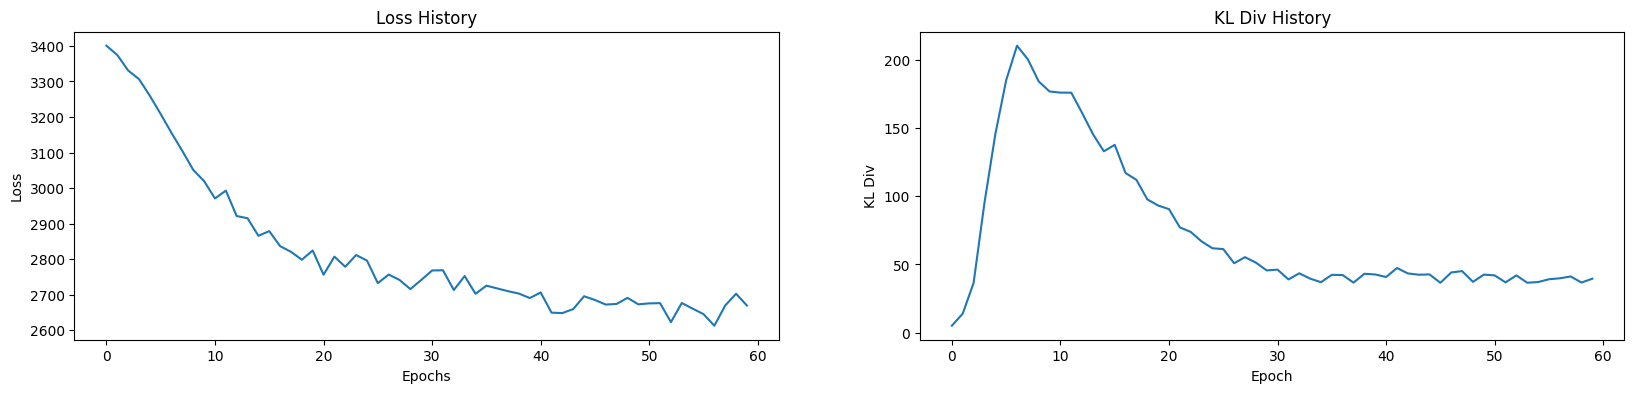

In [9]:
# Plotting
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.plot(loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss History")

plt.subplot(1,2,2)
plt.plot(kl_div_history)
plt.xlabel("Epoch")
plt.ylabel("KL Div")
plt.title("KL Div History")

plt.show()

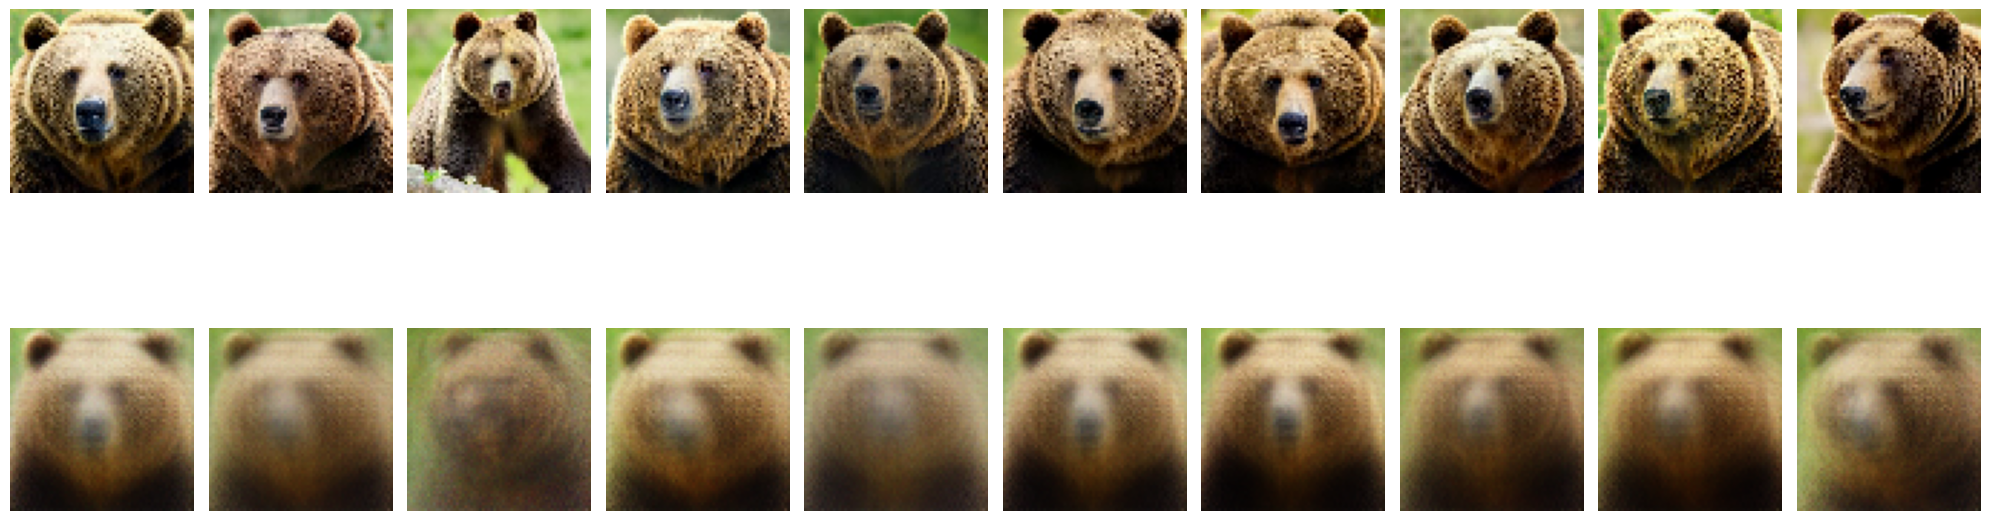

In [10]:
# Implement model for reconstruction test data
mu, log_var = model.encode(x_test.reshape(-1, IMAGE_SIZE))
z = model.reparameterize(mu, log_var)

out = model.decode(z)
out = tf.reshape(out, [-1, IMAGE_ORIGINAL_SHAPE[0], IMAGE_ORIGINAL_SHAPE[1], IMAGE_ORIGINAL_SHAPE[2]]).numpy() * 255
out = out.astype(np.uint8)

number = 10
plt.figure(figsize=(20, 8))

for index in range(number):
    ax = plt.subplot(2, number, index+1)
    plt.imshow(x_test[index].reshape(64, 64, 3))
    ax.axis('off')

for index in range(number):
    ax = plt.subplot(2, number, number + index + 1)
    plt.imshow(out[index])
    ax.axis('off')

plt.tight_layout()
plt.show()